<a href="https://colab.research.google.com/github/wdwzyyg/Atom-Finder/blob/main/Exp_Datapre%26collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import scipy
import scipy.fftpack as syfp
from scipy import ndimage as ndi
from scipy import optimize
from skimage.feature import peak_local_max
from skimage.morphology import local_maxima
from pylab import *
from PIL import Image
import glob
import os 
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import numpy as np
def map01(mat):
    return (mat - mat.min())/(mat.max() - mat.min())
import shutil

#### TEM.NET

In [ ]:
nbtype = !python -c "import google.colab" 2>/dev/null; echo $?
if not int(nbtype[0]):
    !git clone https://github.com/xinhuolin/TEM-ImageNet-v1.3.git
    !cp -r noNoiseNoBackgroundSuperresolution/ .

/content/TEM-ImageNet-v1.3/params/08594.txt


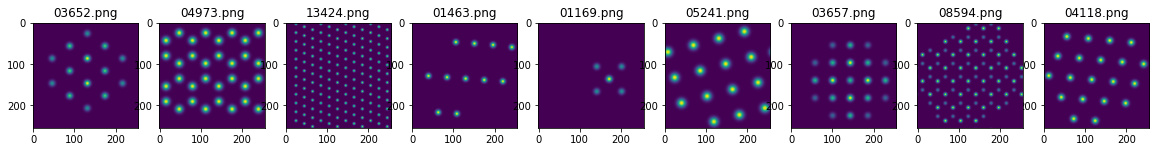

In [ ]:
filelist = os.listdir('/content/TEM-ImageNet-v1.3/noNoiseNoBackgroundSuperresolution')
filelist = filelist[920:929]
i = -1
fig = plt.figure(figsize=(20,30))
for file in filelist:
  i = i+1
  ax = fig.add_subplot('19{}'.format(i))
  im = Image.open('/content/TEM-ImageNet-v1.3/noNoiseNoBackgroundSuperresolution/' + file) 
  ax.imshow(im)
  ax.set_title(file)


In [ ]:
f = open('/content/TEM-ImageNet-v1.3/params/08594.txt', "r") 
print(f.read()) 
im = Image.open('/content/TEM-ImageNet-v1.3/noNoiseNoBackgroundSuperresolution/' + '08594.png') 
im.save('/content/drive/My Drive/AtomfinderProject/Data/WS2/Simu/origin.tif')

 21.615994078459589645 
                    0 
                    0 
                    0 
                    0 
                  100 
                    0 
                   30 
 0.80000000000000004441 
                   16 
                   30 
 0.22854748754002582323 
 0.22854748754002582323 



####Read ser file of experiment

In [ ]:
!pip install hyperspy[all]
!pip install numba==0.49
!pip install ipython==6.0

In [11]:
import hyperspy.api as hs

# will write Dimension	Pixel size(pm) /Mag	Contrast
def extractinfo(serfilepath):
  s = hs.load(serfilepath)
  dimention = (s.axes_manager["y"].size,s.axes_manager["y"].size)
  pxsize = s.axes_manager["x"].scale*1000
  sarray = np.asarray(s)
  peak_inte = sarray.max()
  contrast = (sarray.max()-sarray.min())/sarray.max()
  print(dimention[1],'*',dimention[0],',\npxsize',
        round(pxsize,2),'pm,\ncontrast',round(contrast,3),',\npeakint',peak_inte,'\n') 
  return pxsize, contrast,peak_inte

In [8]:
## Check all ser files in folder and save the useful ones

loadpath = '/content/drive/MyDrive/TitanBackup/20200714/'

filelist = os.listdir(loadpath)
for file in filelist:

  try:
    _,surfix = os.path.splitext(file)
    if surfix == '.ser':
      #extractinfo(loadpath+file)
      s = hs.load(loadpath+file)
      s.plot()
  except:
    continue

In [12]:
loadpath = '/content/drive/MyDrive/TitanBackup/20200714/'
serlist = []
filelist = sort(os.listdir(loadpath))
for file in filelist:

  try:
    _,surfix = os.path.splitext(file)
    if surfix == '.ser':
      serlist.append(file)
  except:
    continue

Check one by one here

512 * 512 ,
pxsize 30.94 pm,
contrast 0.523 ,
peakint 6030 



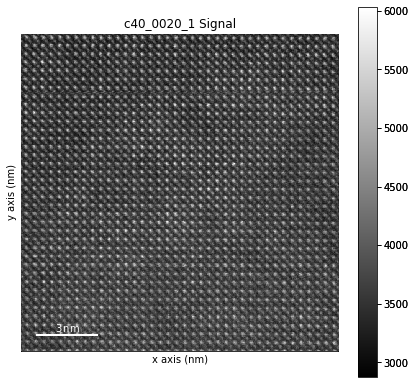

In [20]:
path = loadpath+serlist[17]
pathe = path[:-6]+'.emi'
#pathe = '/content/drive/MyDrive/TitanBackup/20201114/14.23.02 Scanning Acquire.emi'

px, c, _ = extractinfo(path)
s = hs.load(path)
s.plot()

Contrast: 0.5230514096185738 max 6030


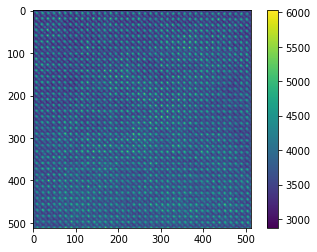

In [21]:
# change contrast by add background 
# try to control the contrast at constant value: 0.6

scut = np.asarray(s)
factor = 0
background = factor*np.ones((512, 512))
#background = factor*np.ones((1024, 1024))
#background = factor*np.ones((256, 256))
new = np.clip( scut - background, a_min = 0, a_max = scut.max())

contrast = (new.max()-new.min())/new.max()
plt.imshow(new)
plt.colorbar()
print("Contrast:",contrast,'max',scut.max()  )

In [ ]:
#Save np array and 8-bit tif
newpath = '/content/drive/MyDrive/AtomfinderProject/Data/STO-exp/DiffMag/'
#os.mkdir(newpath+str(px)[:5]+'pm/')
fn = str(px)[:5]+'pm'
shutil.copy(path,newpath+fn+'/'+fn+'.ser')
shutil.copy(pathe,newpath+fn+'/'+fn+'.emi')

sarray = np.asarray(new)
np.save(newpath+fn+'/'+fn+'.npy',sarray)
im= (map01(sarray) * 255).astype('uint8')
plt.imshow(im)
plt.colorbar()
im = Image.fromarray(im, 'L')
im.save(newpath+fn+'/'+fn+'.tif')

#### Find ground truth of exp data

First find all the atom peaks as ground truth

then limit the threshold to find only the atoms that you want to calculate precision from, called UnaryPeaks_x/y

(256, 256)
Coordinate:  (686, 2)
Coordinate now:  (680, 2)


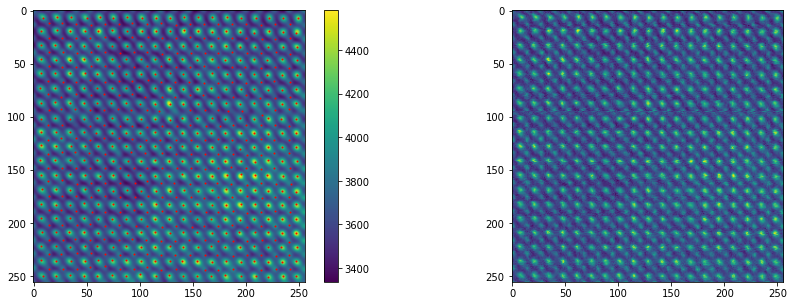

In [22]:
'''path = newpath+fn+'.tif'
#os.chdir(path)
im = Image.open(path)'''
#im = np.asarray(s.data)
im = new
im = new[:256,:256]
print(im.shape)

image_max = ndi.maximum_filter(im, size =2, mode = 'constant')
imgaussian = ndi.gaussian_filter(im, sigma = 2)
image_max = ndi.maximum_filter(im, size =1, mode = 'constant')

coordinates = peak_local_max(image_max, min_distance = 3, threshold_abs = 0) 
print('Coordinate: ',coordinates.shape)


# the peak_local_max give multiple coordinates with same intensity at flat peak, so try to get rid of them here
co_tempt = coordinates
del_index = []
for i in range(coordinates.shape[0]):
  for j in range(i+1, coordinates.shape[0]):
    dis = math.sqrt((coordinates[i][0]- coordinates[j][0])**2 + (coordinates[i][1] - coordinates[j][1])**2)
###
    if (dis < 6) & (dis > 0):
      del_index.append(j)
coordinates = np.delete(coordinates,del_index,0)
print('Coordinate now: ', coordinates.shape)

fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
plt.imshow(imgaussian)
plt.colorbar()
plt.scatter(np.transpose(coordinates)[1],np.transpose(coordinates)[0],s = 1, c = 'r')

fig.add_subplot(122)
plt.imshow(image_max)

In [ ]:
'''## Get rid of coords in blank area 
del_index = []
for i in range(coordinates.shape[0]):
  if coordinates[i][1]>240:
    del_index.append(i)
coordinates = np.delete(coordinates,del_index,0)
print('Coordinate now: ', coordinates.shape)'''
peak_y_fit, peak_x_fit, edgey, edgex = peakfit(coordinates, im, path,6)
print(peak_y_fit.shape,peak_y_fit.dtype)
'''plt.scatter(np.transpose(coordinates)[1],np.transpose(coordinates)[0],s = 1, c = 'r')'''

In [ ]:
# combine the unfitted edge points and fitted points
peak_y_fit = np.hstack((peak_y_fit, edgey))
peak_x_fit = np.hstack((peak_x_fit, edgex))
print(peak_y_fit.shape, peak_x_fit.shape)
fig = plt.figure(figsize=(5,5))
plt.imshow(imgaussian)
plt.colorbar()
plt.scatter(peak_x_fit, peak_y_fit, s = 1, c = 'r')

Sometimes for the complicated exp image, atom Sr and Ti have different radius, which lead to error of peakfit. Try identify sublattice seperately. 

In [ ]:
savepath = newpath+fn+'/'
np.save(savepath+'Peaks_x.npy', np.asarray(peak_x_fit))
np.save(savepath+'Peaks_y.npy', np.asarray(peak_y_fit))

In [ ]:
plt.imshow(imgaussian)
plt.colorbar()
a = [456,461]
plt.scatter((peak_x_fit[456],peak_x_fit[461]),(peak_y_fit[456],peak_y_fit[461]),s = 1, c = 'r')

In [ ]:
### Check

x = int(peak_x_fit[11])
y = int(peak_y_fit[11])
print(x,y)
patcha = im[y-7:y+7,x-7:x+7]
plt.imshow(patcha)
bg = np.amin(patcha)
guess = (bg,im[7,7]-bg,7, 7,3, 3)
bounds = ([0,0,0,0,1,1],[np.inf,np.inf,20,20, 18, 18])
param = fitGaussianx2(patcha, guess, bounds)
print(param)
plt.scatter(param[2],param[3])
print(param[2],param[3])
print(param[2]+x-7,param[3]+y-7)

# Aux function

In [17]:
def peakfit(coordinates, im, path,size):
  peak_x_fit = []
  peak_y_fit = []
  egde_x = []
  egde_y = []
  for i in range(coordinates.shape[0]):

    x = int(coordinates[i][1])
    y = int(coordinates[i][0])
    if (y < size) or (y > (im.shape[0]-1-size)) or (x < size) or (x > (im.shape[0]-1-size)):
      egde_x.append(coordinates[i][1])
      egde_y.append(coordinates[i][0])
      continue

    patch = im[y-size:y+size, x-size:x+size]
    bg = np.amin(patch)  # minimum value within im
    guess = (bg, patch[size,size]-bg, size, size, (size-1)/2, (size-1)/2)
    bounds = ([min(0,bg), 0, 0, 0, 1, 1], [np.inf, np.inf, size*2, size*2, size*2-2, size*2-2])
#    print('bounds', bounds) 
#    print('guess', guess)
    param = fitGaussianx2(patch, guess, bounds)

    peak_x_fit.append(param[2]+x-size)
    peak_y_fit.append(param[3]+y-size)

  fig = plt.figure(figsize = (5,5))
  im0 = plt.imshow(im, cmap = plt.cm.gray)
  fig = colorbar(im0)
  plt.scatter(peak_x_fit, peak_y_fit,s = 1, c = 'b')


  plt.xticks([]) 
  plt.yticks([])

  peak_x_fit = np.asarray(peak_x_fit)
#  np.save(path+'Peaks_x.npy', np.asarray(peak_x_fit))
  peak_y_fit = np.asarray(peak_y_fit)
#  np.save(path+'Peaks_y.npy', np.asarray(peak_y_fit))  
  return peak_y_fit, peak_x_fit, egde_y, egde_x

def gaussianx2(xdata_tuple, bg, height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel() 

def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    ## Parameter here
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=1000000)
    return popt

In [ ]:
#calculate precision from coordinate

def FindPrecision(peaks_x,peaks_y,intensity,threshold,separation,est_spacing):
  '''
# Only effective if the Sr/Ti peak intensity is distinguishable 
# Refered to https://github.com/CY-Zhang/PyProcessingCodes/blob/master/JDDC/DoseTest_exp.ipynb
# Threshold: only atoms intensity above the threshold will be counted
# Separation: set to be half the atom radius in px, define range of points to calculate std deviation
# The remain atom grid should be tetragons. 
  '''
  peaks_int = []
  for i in range(len(peaks_x)):
    c= (int(peaks_y[i]),int(peaks_x[i]))
    peaks_int.append(float(intensity[c]))

  array_x = np.asarray(peaks_x)
  array_y = np.asarray(peaks_y)
  array_int = np.asarray(peaks_int)
  print('array_x',len(array_x),'array_y',len(array_y), 'array_int',len(array_int))
#
  index = np.where((array_x>50) & (array_x<1000) & (array_y > 50) & (array_y < 1000) & (array_int>0))
  array_x = array_x[index]
  array_y = array_y[index]
  array_int = array_int[index]
  print('After cut edge: array_x',len(array_x),'array_y',len(array_y), 'array_int',len(array_int))

  hist_bin = np.arange(np.amin(array_int),np.amax(array_int),2) #start,stop,step
  fig = plt.subplots(figsize=(6,2))
  plt.hist(array_int, bins=hist_bin)
  plt.title('Peak Intensity Histogram')

#     hist, bin_edges = np.histogram(array_int,bins=np.arange(np.amin(array_int)+0.5,np.amax(array_int),0.2), density=True)
#     threshold = bin_edges[argmin(hist)]
#  threshold = np.sort(array_int)[-5]
  print('Threshold',threshold)
  lattice1 = np.where(array_int>threshold)
  array_x1 = array_x[lattice1]
  array_y1 = array_y[lattice1]
  array_int1 = array_int[lattice1]
  print('After threshold: array_x',len(array_x1),'array_y',len(array_y1), 'array_int',len(array_int1))  
  fig = plt.subplots(figsize=(5,5))
  plt.scatter(array_x1,array_y1,s = 1)

  return FindXStd(array_x1,array_y1,separation,est_spacing), FindYStd(array_x1,array_y1,separation,est_spacing)

def FindYStd(array_x1_copy,array_y1_copy,separation,est_spacing):
    y_sep = []
    while array_x1_copy.size != 0:
        x_cor = array_x1_copy[0]
        index = np.where((array_x1_copy<x_cor+separation) & (array_x1_copy>x_cor-separation))
        array_y_sub = array_y1_copy[index]
        array_y_sub = np.sort(array_y_sub)
        for i in range(array_y_sub.shape[0]-1):
            spacing = array_y_sub[i+1] - array_y_sub[i]
            if (spacing < est_spacing + separation) & (spacing > est_spacing - separation):
                y_sep.append(spacing)
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)
    print('Total counted y spacing number: ',len(y_sep))
    y_std = np.std(np.asarray(y_sep))
#     fig = plt.subplots(figsize=(6,2))
#     plt.hist(y_sep, bins='auto')
#     plt.title('Hist along y, std= '+str(y_std))
    return y_std


def FindXStd(array_x1_copy,array_y1_copy,separation,est_spacing):
    x_sep = []
    while array_x1_copy.size != 0:
        y_cor = array_y1_copy[0]
        index = np.where((array_y1_copy<y_cor+separation) & (array_y1_copy>y_cor-separation))
        array_x_sub = array_x1_copy[index]
        array_x_sub = np.sort(array_x_sub)
        for i in range(array_x_sub.shape[0]-1):
            spacing = array_x_sub[i+1] - array_x_sub[i]
            if (spacing < est_spacing + separation) & (spacing > est_spacing - separation):
                x_sep.append(array_x_sub[i+1] - array_x_sub[i])
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)
    print('Total counted x spacing number: ',len(x_sep))
    x_std = np.std(np.asarray(x_sep))
#     fig = plt.subplots(figsize=(6,2))
#     plt.hist(x_sep, bins='auto')
#     plt.title('Hist along x, std= '+str(x_std))
    return x_std

# deviation not used now

In [ ]:
#calculate precision from WS2 coordinate
from scipy.spatial import distance
import statistics

points = np.asarray(np.transpose(np.vstack((peak_y_fit,peak_x_fit))))
distances = distance.cdist(points, points, 'euclidean')
print(np.histogram(distances))
#plt.hist(distances)

distances_avai = distances[(distances < 200) & (distances > 3)]
plt.hist(distances_avai)
#print("Standard Deviation of distances is % s px" % (statistics.stdev(distances_avai))) 

In [ ]:
xp = np.load('/content/drive/My Drive/AtomfinderProject/Data/WS2/Exp/DiffMag/7d89pm/Peaks_x.npy')
yp = np.load('/content/drive/My Drive/AtomfinderProject/Data/WS2/Exp/DiffMag/7d89pm/Peaks_y.npy')
im = np.load('/content/drive/My Drive/AtomfinderProject/Data/WS2/Exp/DiffMag/7d89pm/7d89pm.npy')
pre = FindPrecision(xp,yp,im,0,5,20)
print('X and Y Precision in pm:(',round(21.91*pre[0],2),',',round(21.91*pre[1],2),')')



# Write csc metadata


In [ ]:

 = '/content/drive/My Drive/AtomfinderProject/Data/WS2/Exp/DiffMag/15d47pm/'    
 # field names  
 fields = ['Material',	'Structure type',	'Space group' ,	
           'Zone axis',	'Dimension',	'Pixel size(pm) /Mag',
                     'Contrast',	'Resolution(pm)',	'Dwel time(us)',	'Quality',	'Source','Precison(x/pm,y/pm)']  
                         
                         # data rows of csv file  
                         '''rows =ter = csv.writer(csvfile)  
        
    # writing the fields  
    csvwriter.writerow(fields)  
        
    # writing the data rows  
    csvwriter.writerow(rows)

# Check if the coords of NRR suit single frame

In [ ]:
# Check if the coords of NRR suit single frame
fig = plt.figure(figsize=(5,5))
singleim = Image.open('/content/drive/My Drive/AtomfinderProject/data/ExpData/DiffDose/4us/HAADF_000.tif')
plt.imshow(singleim)
plt.colorbar()
plt.scatter(peak_x_fit, peak_y_fit,s = 2, c = 'r')